# Download Data

In [1]:
import glob
import json
import os
import re
import zipfile
from urllib.request import urlretrieve

import pandas as pd
import requests

In [2]:
# Necessary metadata
article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figshareairline/"

To send a GET request to list the available files:

In [3]:
response = requests.request("GET", url, headers=headers)
data = json.loads(
    response.text
)  # this contains all the articles data, feel free to check it out
files = data["files"]  # this is just the data about the files, which is what we want
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

To get the file named `data.zip`:

In [4]:
%%time
files_to_dl = ["data.zip"]  # feel free to add other files here
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: user 4.81 s, sys: 3.66 s, total: 8.46 s
Wall time: 40.1 s


In [5]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), "r") as f:
    f.extractall(output_directory)

CPU times: user 14.6 s, sys: 1.14 s, total: 15.7 s
Wall time: 16.2 s


# Combine Data CSVs

To combine all these files using python:

In [6]:
%%time
import pandas as pd

files = glob.glob("figshareairline/*.csv")
try:
    files.remove(os.path.join("figshareairline", "observed_daily_rainfall_SYD.csv"))
except:
    pass
try:
    files.remove(os.path.join("figshareairline", "combined_data.csv"))
except:
    pass
            
df = pd.concat(
    (
        pd.read_csv(file, index_col=False)
        .assign(
            file_name=re.findall("[ \w-]+\.", file)[0],
            model=lambda x: x.file_name.str.split("_", expand=True)[0],
        )
        .drop(columns="file_name")
        for file in files
    )
)
df.to_csv("figshareairline/combined_data.csv")

CPU times: user 11min 3s, sys: 2min 17s, total: 13min 20s
Wall time: 15min 3s


In [7]:
%%sh
du -sh figshareairline/combined_data.csv

6.0G	figshareairline/combined_data.csv


In [8]:
df.shape

(62467843, 7)

In [9]:
df.head()

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1,1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
2,1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
3,1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
4,1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


### Run Times:

| Team Member | Operating System | RAM | Processor | Is SSD | CPU times | Wall time |
| --- | --- | --- | --- | --- | --- | --- |
| Alex | --- | --- | --- | --- | 5min 10s | 5min 29s |
| Harry | --- | --- | --- | --- | 12min 12s | 15min 22s |
| Brandon | macOS | 16GB | Apple M1 | Yes | 13min 20s | 15min 3s |
| Anthea | --- | --- | --- | --- | --- | --- |

### Summary:
> TBC

# Load the combined CSV to memory and perform a simple EDA

Let's first load the combined CSV to memory.

In [5]:
%%time
df = pd.read_csv("figshareairline/combined_data.csv", index_col=0)
print(df["model"].value_counts())

MPI-ESM1-2-HR       5154240
CMCC-CM2-HR4        3541230
CMCC-ESM2           3541230
CMCC-CM2-SR5        3541230
NorESM2-MM          3541230
TaiESM1             3541230
SAM0-UNICON         3541153
GFDL-ESM4           3219300
FGOALS-f3-L         3219300
GFDL-CM4            3219300
MRI-ESM2-0          3037320
EC-Earth3-Veg-LR    3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
FGOALS-g3           1287720
KIOST-ESM           1287720
AWI-ESM-1-1-LR       966420
MPI-ESM1-2-LR        966420
NESM3                966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64
CPU times: user 51.2 s, sys: 14.1 s, total: 1min 5s
Wall time: 1min 12s


Run Times:

| Team Member | Operating System | RAM | Processor | Is SSD | CPU times | Wall time |
| --- | --- | --- | --- | --- | --- | --- |
| Alex | --- | --- | --- | --- | --- | --- |
| Harry | --- | --- | --- | --- | --- | --- |
| Brandon | macOS | 16GB | Apple M1 | Yes | 1min 6s | 1min 26s |
| Anthea | --- | --- | --- | --- | --- | --- |

In [6]:
df.describe()

,lat_min,lat_max,lon_min,lon_max,rain (mm/day)
count,5.924854e+07,6.246784e+07,5.924854e+07,6.246784e+07,5.924854e+07
mean,-3.310482e+01,-3.197757e+01,1.469059e+02,1.482150e+02,1.901170e+00
std,1.963549e+00,1.992067e+00,3.793784e+00,3.809994e+00,5.585735e+00
min,-3.646739e+01,-3.600000e+01,1.406250e+02,1.412500e+02,-3.807373e-12
25%,-3.486911e+01,-3.366221e+01,1.434375e+02,1.450000e+02,3.838413e-06
50%,-3.300000e+01,-3.204188e+01,1.468750e+02,1.481250e+02,6.154947e-02
75%,-3.140170e+01,-3.015707e+01,1.501875e+02,1.513125e+02,1.020918e+00
max,-2.990000e+01,-2.790606e+01,1.537500e+02,1.556250e+02,4.329395e+02


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62467843 entries, 0 to 3541152
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   lat_min        float64
 2   lat_max        float64
 3   lon_min        float64
 4   lon_max        float64
 5   rain (mm/day)  float64
 6   model          object 
dtypes: float64(5), object(2)
memory usage: 3.7+ GB


### Loading only columns we need
It takes 3.7GB of memery! To reduce the use of memory, let's try loading only the columns (e.g. "time" and "rain(mm/day)") we need.

In [8]:
%%time
use_cols = ['time','rain (mm/day)']
df_columns = pd.read_csv("figshareairline/combined_data.csv",usecols=use_cols)

CPU times: user 34.6 s, sys: 4.21 s, total: 38.8 s
Wall time: 41 s


Run Times:

| Team Member | Operating System | RAM | Processor | Is SSD | CPU times | Wall time |
| --- | --- | --- | --- | --- | --- | --- |
| Alex | --- | --- | --- | --- | --- | --- |
| Harry | --- | --- | --- | --- | --- | --- |
| Brandon | macOS | 16GB | Apple M1 | Yes | 38.8s | 41s |
| Anthea | --- | --- | --- | --- | --- | --- |

In [9]:
df_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62467843 entries, 0 to 62467842
Data columns (total 2 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   rain (mm/day)  float64
dtypes: float64(1), object(1)
memory usage: 953.2+ MB


The memory usage greatly reduced to 953.2MB by just loading the columns we need. The runtime also greatly reduced from ~1min 9s to 39s [TBD] in average.

### Changing dtype
The dtype for lat_min, lat_max, lon_min, lon_max and rain (mm/day) are all float64. To reduce the use of memeory, we can change the dtype to float32 as this is good enough for the stored values. The memory usage will be greatly reduced from 2499MB to 1249MB.

In [10]:
print(f"Memory usage with float64: {df[['lat_min','lat_max','lon_min','lon_max','rain (mm/day)']].memory_usage().sum() / 1e6:.2f} MB")
print(f"Memory usage with float32: {df[['lat_min','lat_max','lon_min','lon_max','rain (mm/day)']].astype('float32', errors='ignore').memory_usage().sum() / 1e6:.2f} MB")

Memory usage with float64: 2998.46 MB
Memory usage with float32: 1749.10 MB


In [11]:
df_dtype = df.astype({'lat_min': 'float32',
                      'lat_max': 'float32',
                      'lon_min': 'float32',
                      'lon_max': 'float32',
                      'rain (mm/day)': 'float32'})

### Loading the data in chunks

In [12]:
%%time
counts = pd.Series(dtype=int)
for chunk in pd.read_csv("figshareairline/combined_data.csv", chunksize=10_000_000):
    counts = counts.add(chunk["model"].value_counts(), fill_value=0)
print(counts.astype(int))

ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
AWI-ESM-1-1-LR       966420
BCC-CSM2-MR         3035340
BCC-ESM1             551880
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
CanESM5              551880
EC-Earth3-Veg-LR    3037320
FGOALS-f3-L         3219300
FGOALS-g3           1287720
GFDL-CM4            3219300
GFDL-ESM4           3219300
INM-CM4-8           1609650
INM-CM5-0           1609650
KIOST-ESM           1287720
MIROC6              2070900
MPI-ESM-1-2-HAM      966420
MPI-ESM1-2-HR       5154240
MPI-ESM1-2-LR        966420
MRI-ESM2-0          3037320
NESM3                966420
NorESM2-LM           919800
NorESM2-MM          3541230
SAM0-UNICON         3541153
TaiESM1             3541230
dtype: int64
CPU times: user 49.1 s, sys: 4.23 s, total: 53.3 s
Wall time: 54.8 s


Run Times:

| Team Member | Operating System | RAM | Processor | Is SSD | CPU times | Wall time |
| --- | --- | --- | --- | --- | --- | --- |
| Alex | --- | --- | --- | --- | --- | --- |
| Harry | --- | --- | --- | --- | --- | --- |
| Brandon | macOS | 16GB | Apple M1 | Yes | 53.3s | 54.8s |
| Anthea | --- | --- | --- | --- | --- | --- |

Running the data in chunks also improves the runtime. In average, it took only 53s [TBD].

### EDA

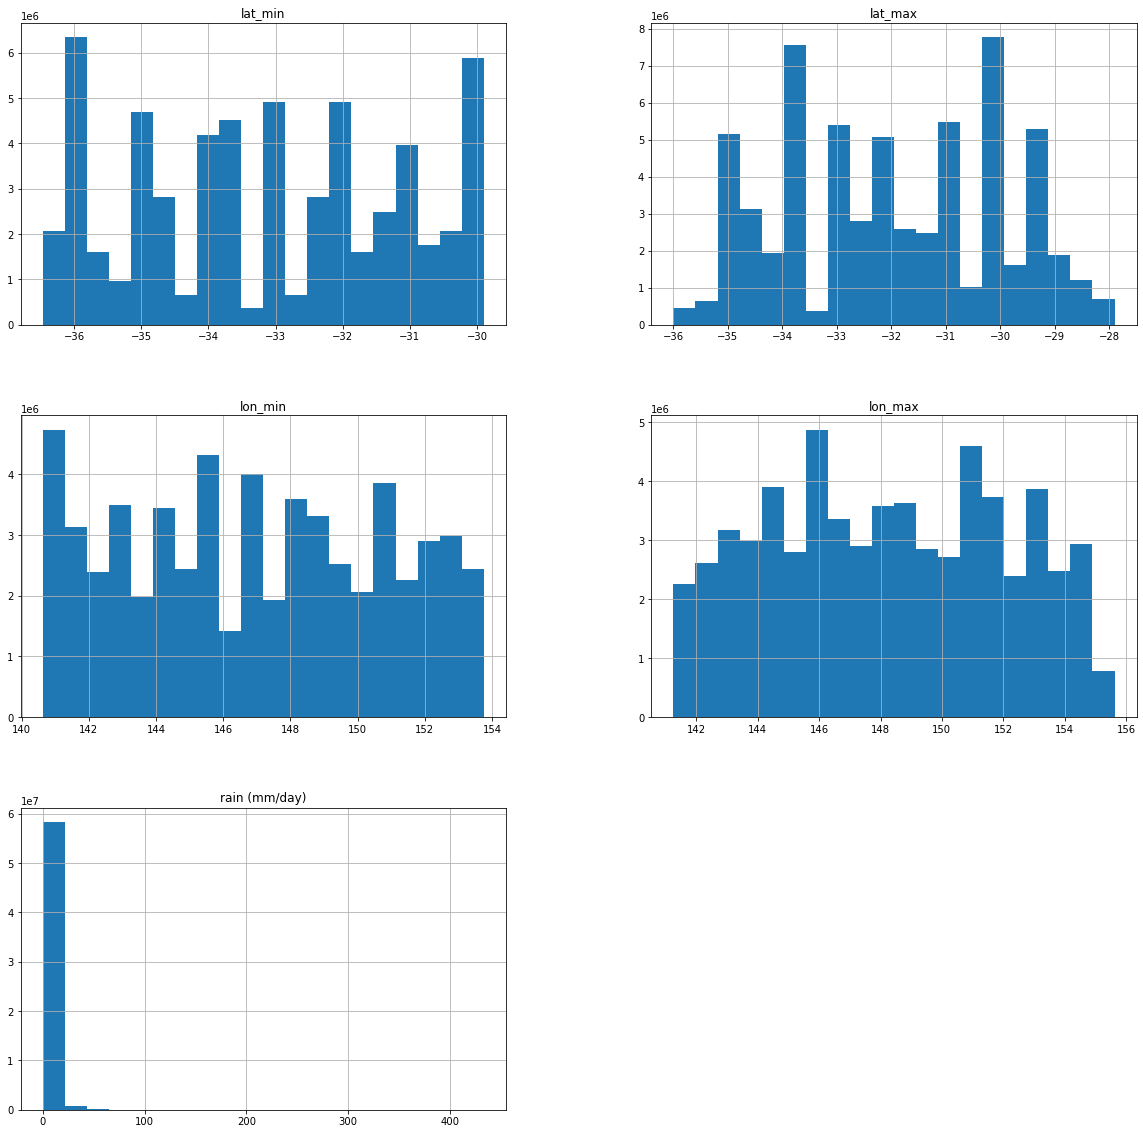

In [13]:
df_dtype.hist(figsize=(20, 20), bins=20);

<AxesSubplot:xlabel='time'>

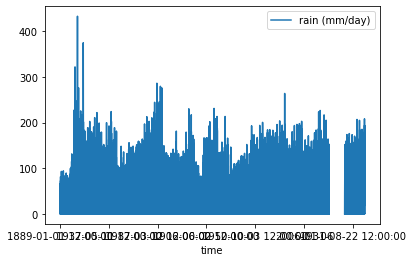

In [19]:
df_dtype.plot.line(y = 'rain (mm/day)', x = 'time')